In [10]:
# Adrian Marinovich
# Springboard - Data Science Career Track 
# Capstone Project #1
# In-depth analysis - Large Smiles Dataset 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import random
import shutil

from scipy.stats import reciprocal, uniform
from scipy.misc import imsave

# for reproducibility:
np.random.seed(41)
tf.reset_default_graph()
tf.set_random_seed(51)
random.seed(61)
os.environ['PYTHONHASHSEED'] = '0'
# to run on CPU only:
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
from keras.models import model_from_yaml
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

from sklearn.svm import LinearSVC 
from sklearn.svm import SVC 

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier

# setup plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


In [4]:
# image plotting functions
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [5]:
# Obtain 'historical' mean and standard deviation,
#  balanced for no and yes smile subset sizes,
#  for use in standardization within generator 
#  (in lieu of StandardScaler)

def print_mean_stdev (file_template='smile_d/*smile*',
                         control_list='smile_control/smileD_train.csv',
                         sample_size=5000):

    random.seed()
    controlnames = [line.rstrip('\n') for line in open(control_list)]
    filenames = list(glob.glob(file_template))
 
    feature_sample = np.zeros((sample_size, 4096))
    
    i = 0
    while i <= (sample_size-1):
        index = random.randint(0,len(controlnames)-1)
        controlname = controlnames[index]
        for filename in filenames:
            if filename[8:] == controlname:
                three = cv2.imread(filename)
                two = three[:,:,0]
                two = two.reshape(-1)
                if filename[8:9] == 'y':
                    feature_sample[i] = two
                    i += 1
                elif (filename[8:9] == 'n') & (random.randrange(100) < 41.03):
                    feature_sample[i] = two
                    i += 1
                break
    print ('Mean:', np.mean(feature_sample),
           '\nStd. dev.:', np.std(feature_sample))

In [6]:
print_mean_stdev()

Mean: 128.4589673828125 
Std. dev.: 44.45422542372712


In [7]:
#
  # All-in-one generator
#

def generate_sample_set(file_template='smile_d/*smile*',
                        control_list='smile_control/smileD_train.csv',
                        chunk_size=10000,
                        random_sample=True,
                        cnn_2d=True,
                        infinite=False,
                        pixel_mean=128.46,
                        pixel_stdev=44.45,
                        preprocess=True,
                        rotate_deg=10,
                        shear_deg=10,
                        zoom_offset=0.05):

    random.seed()
    img_gen = ImageDataGenerator()
    controlnames = [line.rstrip('\n') for line in open(control_list)]
    filenames = list(glob.glob(file_template))
    if infinite == True:
        while True:
            if cnn_2d:
                chunk_features = np.zeros((chunk_size, 64, 64, 1))
                chunk_labels = np.zeros((chunk_size, 1))
            else:
                chunk_features = np.zeros((chunk_size, 4096))
                chunk_labels = np.zeros((chunk_size, 1))        
            i = 0
            while i <= (chunk_size-1):
                if random_sample:
                    index = random.randint(0,len(controlnames)-1)
                else:
                    index = i
                controlname = controlnames[index]
                for filename in filenames:
                    if filename[8:] == controlname:
                        three = cv2.imread(filename)  #(64, 64, 3)
                        one_ = three[:,:,0]  #(64, 64)
                        one1d = one_.reshape(-1)  #(4096,)
                        one1ds = []
                        for pixel in one1d:
                            one1ds.append((pixel.astype(np.float32) - pixel_mean) / pixel_stdev)
                        one1s = np.asarray(one1ds)  #(4096,)
                        one2ds = one1s.reshape(64,64,1)  #(64, 64, 1)
                        if preprocess:
                            theta = random.randint(-rotate_deg,rotate_deg)
                            shear = random.randint(-shear_deg,shear_deg)
                            zoom = random.uniform(1-zoom_offset, 1+zoom_offset)
                            transform_parameters = {'theta': theta, 
                                                    'shear': shear,
                                                    'zx': zoom,
                                                    'zy': zoom}
                            one = img_gen.apply_transform(one2ds, transform_parameters)  #(64, 64, 1)
                        else:
                            one = one2ds
                        if cnn_2d:
                            one_out = one.reshape(-1,64,64,1)  #(1, 64, 64, 1)
                        else:
                            one_out = one.reshape(-1)
                        if filename[8:9] == 'y':
                            chunk_features[i] = one_out
                            chunk_labels[i] = 1
                            i += 1
                        elif (filename[8:9] == 'n') & (random.randrange(100) < 41.03):
                            chunk_features[i] = one_out
                            chunk_labels[i] = 0
                            i += 1
                        break
            yield chunk_features, chunk_labels
    elif infinite == False:
        if cnn_2d:
            chunk_features = np.zeros((chunk_size, 64, 64, 1))
            chunk_labels = np.zeros((chunk_size, 1))
        else:
            chunk_features = np.zeros((chunk_size, 4096))
            chunk_labels = np.zeros((chunk_size, 1))        
        i = 0
        while i <= (chunk_size-1):
            if random_sample:
                index = random.randint(0,len(controlnames)-1)
            else:
                index = i
            controlname = controlnames[index]
            for filename in filenames:
                    if filename[8:] == controlname:
                        three = cv2.imread(filename)  #(64, 64, 3)
                        one_ = three[:,:,0]  #(64, 64)
                        one1d = one_.reshape(-1)  #(4096,)
                        one1ds = []
                        for pixel in one1d:
                            one1ds.append((pixel.astype(np.float32) - pixel_mean) / pixel_stdev)
                        one1s = np.asarray(one1ds)  #(4096,)
                        one2ds = one1s.reshape(64,64,1)  #(64, 64, 1)
                        if preprocess:
                            theta = random.randint(-rotate_deg,rotate_deg)
                            shear = random.randint(-shear_deg,shear_deg)
                            zoom = random.uniform(1-zoom_offset, 1+zoom_offset)
                            transform_parameters = {'theta': theta, 
                                                    'shear': shear,
                                                    'zx': zoom,
                                                    'zy': zoom}
                            one = img_gen.apply_transform(one2ds, transform_parameters)  #(64, 64, 1)
                        else:
                            one = one2ds
                        if cnn_2d:
                            one_out = one.reshape(-1,64,64,1)  #(1, 64, 64, 1)
                        else:
                            one_out = one.reshape(-1)
                        if filename[8:9] == 'y':
                            chunk_features[i] = one_out
                            chunk_labels[i] = 1
                            i+=1
                        elif (filename[8:9] == 'n') & (random.randrange(100) < 41.03):
                            chunk_features[i] = one_out
                            chunk_labels[i] = 0
                            i+=1
                        break
        yield chunk_features, chunk_labels

In [ ]:
#
# Decision Tree
#

In [8]:
# Decision tree, entropy: fit
etree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4000, random_state=33)
for x, y in generate_sample_set(chunk_size=10000, cnn_2d=False):
    etree_clf.fit(x, y)

# Decision tree, entropy: predict
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_valid.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    etree_labels_pred = etree_clf.predict(x)
    print(accuracy_score(y, etree_labels_pred))

0.722


In [9]:
#
# Random forest
#

In [10]:
# Random forest, entropy: fit
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=33)
for x, y in generate_sample_set(chunk_size=10000, cnn_2d=False):
    rf_clf.fit(x, y)

# Random forest, entropy: predict
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_valid.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    rf_pred = rf_clf.predict(x)
    print(accuracy_score(y, rf_pred))

0.8555


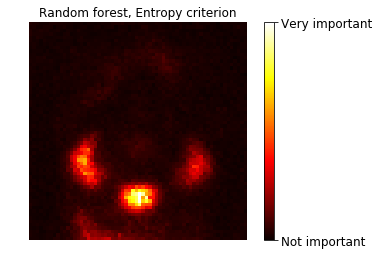

In [11]:
# Plot the pixels according to their importance as features
# (adapted from: 
#    https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb  )
def plot_feat_imp(data):
    image = data.reshape(64, 64)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_feat_imp(rf_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.title('Random forest, Entropy criterion')
plt.show()

In [ ]:
#
# SVM
#

In [13]:
# SVC with an RBF kernel, one-vs-one
svm_clf = SVC(decision_function_shape="ovo")
for x, y in generate_sample_set(chunk_size=10000, cnn_2d=False):
    svm_clf.fit(x, y)

In [ ]:
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_train.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    y_train_svm = svm_clf.predict(x)
    print('On train, SVM-RBF accuracy is:', accuracy_score(y, y_train_svm))

In [14]:
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_valid.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    y_train_svm = svm_clf.predict(x)
    print('On valid, SVM-RBF accuracy is:', accuracy_score(y, y_train_svm))

On valid, SVM-RBF accuracy is: 0.8525


In [ ]:
#
# DNN
#

In [18]:
# (adapted from:
#    https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/ )

del dnn_clf

dnn_clf = Sequential()
dnn_clf.add(Dense(1000, input_dim=4096, activation='relu'))
dnn_clf.add(Dense(200, activation='relu'))
dnn_clf.add(Dense(1, activation='sigmoid'))

In [19]:
dnn_clf.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [20]:
svm_clf = SVC(decision_function_shape="ovo")
for x, y in generate_sample_set(chunk_size=10000, cnn_2d=False):
    dnn_clf.fit(x, y, epochs=30, batch_size=10, shuffle=False)

Epoch 1/30
10000/10000 [==============================] - 14s 1ms/step - loss: 0.4141 - acc: 0.8133
Epoch 2/30
10000/10000 [==============================] - 5s 460us/step - loss: 0.2971 - acc: 0.8740
Epoch 3/30
10000/10000 [==============================] - 5s 457us/step - loss: 0.2391 - acc: 0.9014
Epoch 4/30
10000/10000 [==============================] - 5s 459us/step - loss: 0.1884 - acc: 0.9277
Epoch 5/30
10000/10000 [==============================] - 5s 459us/step - loss: 0.1429 - acc: 0.9488
Epoch 6/30
10000/10000 [==============================] - 5s 460us/step - loss: 0.1042 - acc: 0.9683
Epoch 7/30
10000/10000 [==============================] - 5s 458us/step - loss: 0.0711 - acc: 0.9833
Epoch 8/30
10000/10000 [==============================] - 5s 460us/step - loss: 0.0538 - acc: 0.9881
Epoch 9/30
10000/10000 [==============================] - 5s 457us/step - loss: 0.0426 - acc: 0.9901
Epoch 10/30
10000/10000 [==============================] - 5s 460us/step - loss: 0.0373 - ac

In [ ]:
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_train.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    y_t_dnn = dnn_clf.predict(x)
    y_t_dnn_round = [round(f[0]) for f in y_t_dnn]
    print('On train, DNN accuracy is:', accuracy_score(y, y_t_dnn_round))

In [21]:
for x, y in generate_sample_set(chunk_size=2000, 
                                control_list='smile_control/smileD_valid.csv', 
                                preprocess=False, 
                                cnn_2d=False):
    y_valid_dnn = dnn_clf.predict(x)
    y_v_dnn_round = [round(f[0]) for f in y_valid_dnn]
    print('On valid, DNN accuracy is:', accuracy_score(y, y_v_dnn_round))

On valid, DNN accuracy is: 0.8695


In [ ]:
#
# CNN
#

In [ ]:
# (adapted from:
#   https://towardsdatascience.com/image-recognition-with-keras-convolutional-neural-networks-e2af10a10114)

In [22]:
# CNN - Conv2D layers: 64, 32

#del cnn_clf2f

cnn_clf2f = Sequential()
cnn_clf2f.add(Conv2D(64, (3, 3), input_shape=(64, 64, 1),
               activation='relu'))
cnn_clf2f.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2f.add(Conv2D(32, (3, 3), activation='relu'))
cnn_clf2f.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2f.add(Flatten())

cnn_clf2f.add(Dense(units=128, activation='relu'))
cnn_clf2f.add(Dense(units=1, activation='sigmoid'))

In [23]:
cnn_clf2f.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])

In [24]:
history_0=cnn_clf2f.fit_generator(generate_sample_set(file_template='smile_d/*smile*',
                                                      control_list='smile_control/smileD_train.csv',
                                                      chunk_size=16,
                                                      cnn_2d=True,
                                                      infinite=True,
                                                      preprocess=True,
                                                      rotate_deg=10,
                                                      shear_deg=10,
                                                      zoom_offset=0.05), 
                                  epochs=10,
                                  steps_per_epoch=300,
                                  validation_data=generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                                                      chunk_size=200,
                                                                      infinite=True,
                                                                      preprocess=False),
                                  validation_steps=10,
                                  shuffle=False,
                                  use_multiprocessing=False)

Epoch 1/10
300/300 [==============================] - 187s 622ms/step - loss: 0.4508 - acc: 0.7760 - val_loss: 0.3095 - val_acc: 0.8635
Epoch 2/10
300/300 [==============================] - 183s 609ms/step - loss: 0.3055 - acc: 0.8710 - val_loss: 0.2981 - val_acc: 0.8845
Epoch 3/10
300/300 [==============================] - 180s 600ms/step - loss: 0.3022 - acc: 0.8744 - val_loss: 0.2542 - val_acc: 0.8910
Epoch 4/10
300/300 [==============================] - 183s 610ms/step - loss: 0.2544 - acc: 0.8973 - val_loss: 0.2141 - val_acc: 0.9180
Epoch 5/10
300/300 [==============================] - 184s 612ms/step - loss: 0.2596 - acc: 0.8894 - val_loss: 0.2529 - val_acc: 0.8960
Epoch 6/10
300/300 [==============================] - 183s 611ms/step - loss: 0.2497 - acc: 0.8958 - val_loss: 0.2389 - val_acc: 0.9070
Epoch 7/10
300/300 [==============================] - 183s 611ms/step - loss: 0.2388 - acc: 0.9050 - val_loss: 0.2100 - val_acc: 0.9095
Epoch 8/10
300/300 [============================

cnn_clf2f = Sequential()

cnn_clf2f.add(Conv2D(64, (3, 3), input_shape=(64, 64, 1),
               activation='relu'))

cnn_clf2f.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2f.add(Conv2D(32, (3, 3), activation='relu'))

cnn_clf2f.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2f.add(Flatten())

cnn_clf2f.add(Dense(units=128, activation='relu'))

cnn_clf2f.add(Dense(units=1, activation='sigmoid'))

In [25]:
# 10 epochs of 300 steps x 16-image batches ... (valid acc 0.879) 

for x, y in generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                chunk_size=2000, 
                                preprocess=False):
    y_valid_cnn = cnn_clf2f.predict(x)
    y_v_cnn_round = [round(y[0]) for y in y_valid_cnn]
    print('On valid, CNN accuracy is:', accuracy_score(y, y_v_cnn_round))

On valid, CNN accuracy is: 0.9205


In [26]:
# CNN - Conv2D layers: 128, 64, 32

#del cnn_clf2e

cnn_clf2e = Sequential()
cnn_clf2e.add(Conv2D(128, (3, 3), input_shape=(64, 64, 1),
               activation='relu'))
cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Conv2D(64, (3, 3), activation='relu'))
cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Conv2D(32, (3, 3), activation='relu'))
cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Flatten())

cnn_clf2e.add(Dense(units=128, activation='relu'))
cnn_clf2e.add(Dense(units=1, activation='sigmoid'))

In [27]:
cnn_clf2e.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])

In [28]:
history_1=cnn_clf2e.fit_generator(generate_sample_set(file_template='smile_d/*smile*',
                                                      control_list='smile_control/smileD_train.csv',
                                                      chunk_size=16,
                                                      cnn_2d=True,
                                                      infinite=True,
                                                      preprocess=True,
                                                      rotate_deg=10,
                                                      shear_deg=10,
                                                      zoom_offset=0.05), 
                                  epochs=10,
                                  steps_per_epoch=600,
                                  validation_data=generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                                                      chunk_size=200,
                                                                      infinite=True,
                                                                      preprocess=False),
                                  validation_steps=1,
                                  shuffle=False,
                                  use_multiprocessing=False)

Epoch 1/10
600/600 [==============================] - 321s 535ms/step - loss: 0.3516 - acc: 0.8459 - val_loss: 0.2695 - val_acc: 0.8850
Epoch 2/10
600/600 [==============================] - 268s 446ms/step - loss: 0.2706 - acc: 0.8897 - val_loss: 0.1923 - val_acc: 0.9450
Epoch 3/10
600/600 [==============================] - 272s 454ms/step - loss: 0.2374 - acc: 0.9040 - val_loss: 0.2592 - val_acc: 0.8800
Epoch 4/10
600/600 [==============================] - 269s 448ms/step - loss: 0.2069 - acc: 0.9195 - val_loss: 0.1716 - val_acc: 0.9350
Epoch 5/10
600/600 [==============================] - 269s 448ms/step - loss: 0.1943 - acc: 0.9222 - val_loss: 0.1961 - val_acc: 0.9050
Epoch 6/10
600/600 [==============================] - 269s 448ms/step - loss: 0.1986 - acc: 0.9197 - val_loss: 0.2693 - val_acc: 0.9100
Epoch 7/10
600/600 [==============================] - 269s 448ms/step - loss: 0.1689 - acc: 0.9333 - val_loss: 0.1422 - val_acc: 0.9550
Epoch 8/10
600/600 [============================

cnn_clf2e = Sequential()

cnn_clf2e.add(Conv2D(128, (3, 3), input_shape=(64, 64, 1),
               activation='relu'))

cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Conv2D(64, (3, 3), activation='relu'))

cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Conv2D(32, (3, 3), activation='relu'))

cnn_clf2e.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf2e.add(Flatten())

cnn_clf2e.add(Dense(units=128, activation='relu'))

cnn_clf2e.add(Dense(units=1, activation='sigmoid'))

In [29]:
# 10 epochs of 600 steps x 16-image batches ... (valid acc 0.9)

for x, y in generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                chunk_size=2000, 
                                preprocess=False):
    y_valid_cnn = cnn_clf2e.predict(x)
    y_v_cnn_round = [round(y[0]) for y in y_valid_cnn]
    print('On valid, CNN accuracy is:', accuracy_score(y, y_v_cnn_round))

On valid, CNN accuracy is: 0.927


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


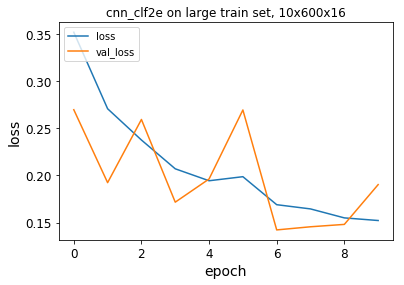

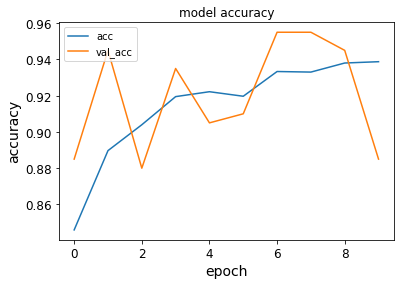

In [30]:
# View loss and accuracy plots:

print(history_1.history.keys())
# Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('cnn_clf2e on large train set, 10x600x16')
plt.show()
# Accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

In [31]:
# CNN - VGG-like model
#   (adapted from:
#      https://keras.io/getting-started/sequential-model-guide/)

#del cnn_clfvgg

cnn_clfvgg = Sequential()
cnn_clfvgg.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), name='conv1a_32'))
cnn_clfvgg.add(Conv2D(32, (3, 3), activation='relu', name='conv1b_32'))
cnn_clfvgg.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
cnn_clfvgg.add(Dropout(0.25))

cnn_clfvgg.add(Conv2D(64, (3, 3), activation='relu', name='conv2a_64'))
cnn_clfvgg.add(Conv2D(64, (3, 3), activation='relu', name='conv2b_64'))
cnn_clfvgg.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
cnn_clfvgg.add(Dropout(0.25))

cnn_clfvgg.add(Flatten())
cnn_clfvgg.add(Dense(256, activation='relu', name='dens1_256'))
cnn_clfvgg.add(Dropout(0.5))
cnn_clfvgg.add(Dense(1, activation='sigmoid', name='dens2_1'))

In [32]:
cnn_clfvgg.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])

cnn_clfvgg = Sequential()

cnn_clfvgg.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), name='conv1a_32'))

cnn_clfvgg.add(Conv2D(32, (3, 3), activation='relu', name='conv1b_32'))

cnn_clfvgg.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))

cnn_clfvgg.add(Dropout(0.25))

cnn_clfvgg.add(Conv2D(64, (3, 3), activation='relu', name='conv2a_64'))

cnn_clfvgg.add(Conv2D(64, (3, 3), activation='relu', name='conv2b_64'))

cnn_clfvgg.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))

cnn_clfvgg.add(Dropout(0.25))

cnn_clfvgg.add(Flatten())

cnn_clfvgg.add(Dense(256, activation='relu', name='dens1_256'))

cnn_clfvgg.add(Dropout(0.5))

cnn_clfvgg.add(Dense(1, activation='sigmoid', name='dens2_1'))

In [48]:
# 5 epochs x 300 steps x 16 ... (0.8895)
# 5 epochs x 600 steps x 16 ... (0.8915)
# 10 epochs x 600 steps x 16 ... (0.937)
# 20 epochs x 600 steps x 16 ... (0.9315)

# This was run on p2.xlarge AWS EC2 instance:

history_3=cnn_clfvgg.fit_generator(generate_sample_set(file_template='smile_d/*smile*',
                                                      control_list='smile_control/smileD_train.csv',
                                                      chunk_size=16,
                                                      cnn_2d=True,
                                                      infinite=True,
                                                      preprocess=True,
                                                      rotate_deg=10,
                                                      shear_deg=10,
                                                      zoom_offset=0.05), 
                                  epochs=10,
                                  steps_per_epoch=600,
                                  validation_data=generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                                                      chunk_size=2000,
                                                                      infinite=True,
                                                                      preprocess=False),
                                  validation_steps=1,
                                  shuffle=False,
                                  use_multiprocessing=False)

for x, y in generate_sample_set(control_list='smile_control/smileD_valid.csv',
                                chunk_size=2000, 
                                preprocess=False):
    y_valid_cnn = cnn_clfvgg.predict(x)
    y_v_cnn_round = [round(y[0]) for y in y_valid_cnn]
    print('On valid, CNN accuracy is:', accuracy_score(y, y_v_cnn_round))

Epoch 1/10
600/600 [==============================] - 554s 924ms/step - loss: 0.1643 - acc: 0.9358 - val_loss: 0.1754 - val_acc: 0.9335
Epoch 2/10
600/600 [==============================] - 548s 913ms/step - loss: 0.1504 - acc: 0.9397 - val_loss: 0.2004 - val_acc: 0.9305
Epoch 3/10
600/600 [==============================] - 375s 625ms/step - loss: 0.1577 - acc: 0.9414 - val_loss: 0.1699 - val_acc: 0.9385
Epoch 4/10
600/600 [==============================] - 318s 530ms/step - loss: 0.1517 - acc: 0.9392 - val_loss: 0.1801 - val_acc: 0.9325
Epoch 5/10
600/600 [==============================] - 317s 529ms/step - loss: 0.1453 - acc: 0.9412 - val_loss: 0.1835 - val_acc: 0.9325
Epoch 6/10
600/600 [==============================] - 317s 528ms/step - loss: 0.1372 - acc: 0.9455 - val_loss: 0.1583 - val_acc: 0.9390
Epoch 7/10
600/600 [==============================] - 315s 526ms/step - loss: 0.1361 - acc: 0.9460 - val_loss: 0.1762 - val_acc: 0.9170
Epoch 8/10
600/600 [============================

In [49]:
# Serialize model to YAML
os.makedirs('models/', exist_ok=True)

cnn_clfvgg20_yaml = cnn_clfvgg.to_yaml()

with open('models/cnn_clfvgg20.yaml', 'w') as yaml_file:
    yaml_file.write(cnn_clfvgg20_yaml)

# Serialize weights to HDF5
cnn_clfvgg.save_weights('models/cnn_clfvgg20_wts.h5')

print('Saved model')

Saved model


In [50]:
# Save history as pickle
with open('models/cnn_clfvgg20_history', 'wb') as file_pi:
        pickle.dump(history_3.history, file_pi)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


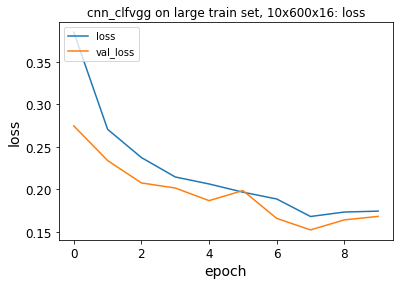

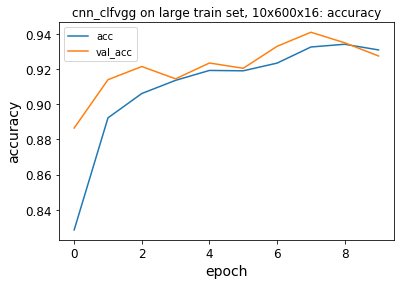

In [65]:
# View loss and accuracy plots - 10 epochs:

print(history_2.history.keys())
# Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('cnn_clfvgg on large train set, 10x600x16: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()
# Accuracy
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('cnn_clfvgg on large train set, 10x600x16: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


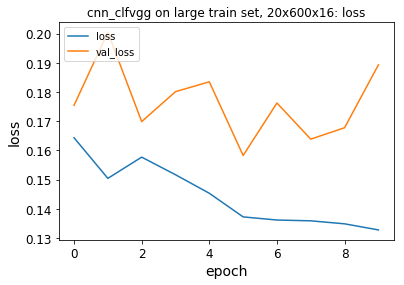

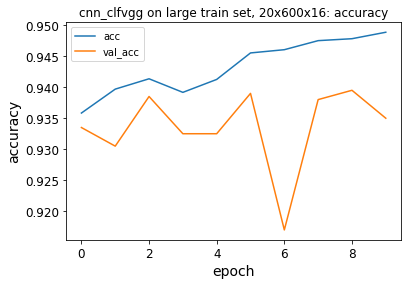

In [64]:
# View loss and accuracy plots - 10 epochs:

print(history_3.history.keys())
# Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('cnn_clfvgg on large train set, 20x600x16: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()
# Accuracy
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('cnn_clfvgg on large train set, 20x600x16: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

In [ ]:
#
# Load saved model and run on hold-out set
#

In [53]:
# Load and create model from YAML
#  (needs Keras version 2.2.4 to run:)
#    in ec2 terminal:
#        pip install Keras==2.2.4

yaml_file = open('models/cnn_clfvgg20.yaml', 'r')
loaded_cnn_clfvgg20_yaml = yaml_file.read()
yaml_file.close()
loaded_cnn_clfvgg20 = model_from_yaml(loaded_cnn_clfvgg20_yaml)

In [54]:
# Load weights into loaded model
loaded_cnn_clfvgg20.load_weights('models/cnn_clfvgg20_wts.h5')
print('Loaded model')

Loaded model


In [55]:
# Predict on hold-out set
#   Note that random_sample, which defaults to True, 
#   is set here as False to bring in full hold-out set

for x, y in generate_sample_set(control_list='smile_control/smileD_hold.csv',
                                chunk_size=646, 
                                random_sample=False,
                                preprocess=False):
    y_hold_cnn = loaded_cnn_clfvgg20.predict(x)
    y_h_cnn_round = [round(y[0]) for y in y_hold_cnn]
    print('On HOLD-OUT (TEST) SET, CNN-VGG accuracy is:', accuracy_score(y, y_h_cnn_round))

On HOLD-OUT (TEST) SET, CNN-VGG accuracy is: 0.9148606811145511


In [56]:
y_pred = np.asarray(y_h_cnn_round)

In [57]:
y_pred.shape

(646,)

In [58]:
yr = np.ravel(y)
yr.shape

(646,)

In [59]:
true_pos = (yr == 1) & (y_pred == 1)
fals_neg = (yr == 1) & (y_pred == 0)
fals_pos = (yr == 0) & (y_pred == 1)
true_neg = (yr == 0) & (y_pred == 0)

In [60]:
true_pos.shape

(646,)

In [61]:
# Individual error review
#  top row: target is smile
#  bottom row: target is no smile
#  left column: model classified as smile
#  right column: model classified as no smile
x1=x.reshape(-1, 4096)
x1.shape

(646, 4096)

In [62]:
def plot_faces(instances, images_per_row=10, **options):
    size = 64
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.gray, **options)
    plt.axis("off")

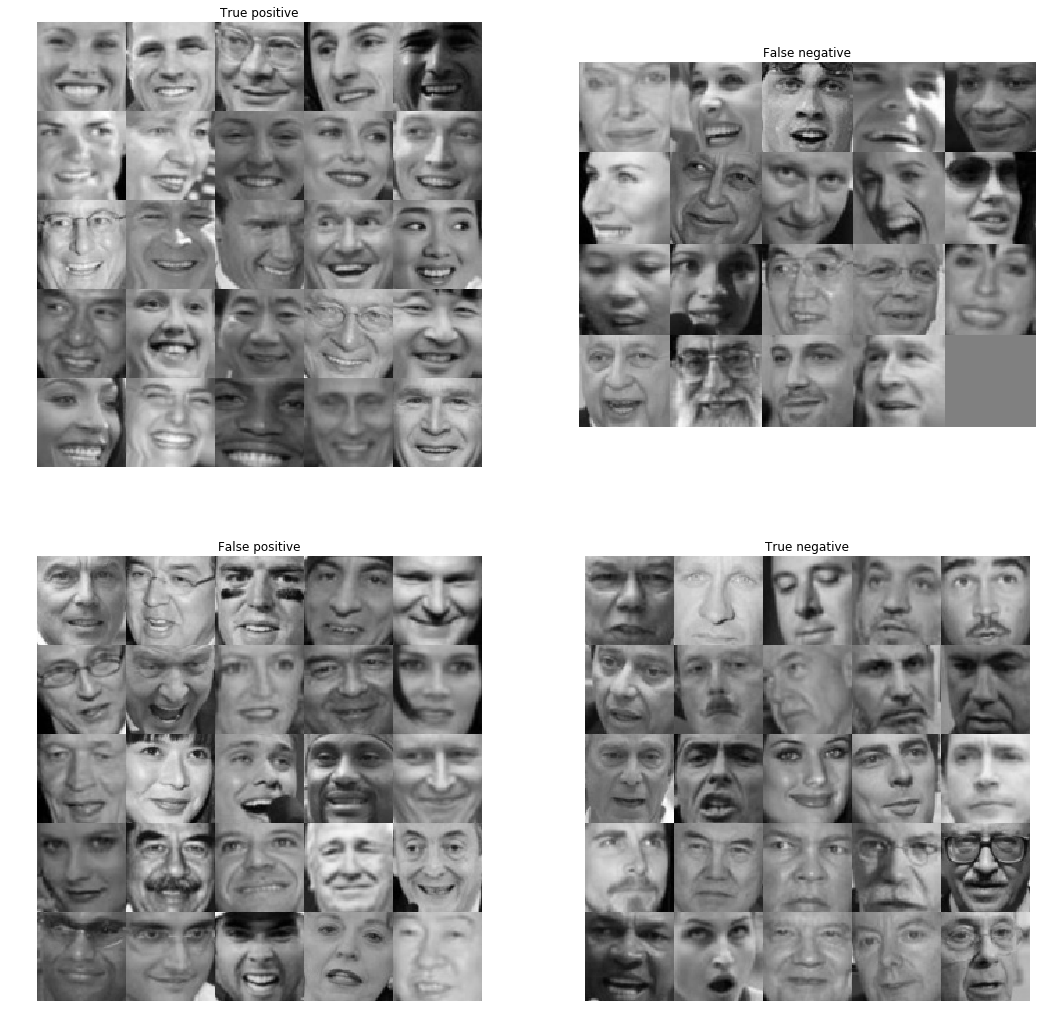

In [63]:
X_aa = x1[true_pos]
X_ab = x1[fals_neg]
X_ba = x1[fals_pos]
X_bb = x1[true_neg]

plt.figure(figsize=(18,18))
plt.subplot(221); plot_faces(X_aa[:25], images_per_row=5)
plt.gca().set_title('True positive')
plt.subplot(222); plot_faces(X_ab[:25], images_per_row=5)
plt.gca().set_title('False negative')
plt.subplot(223); plot_faces(X_ba[:25], images_per_row=5)
plt.gca().set_title('False positive')
plt.subplot(224); plot_faces(X_bb[:25], images_per_row=5)
plt.gca().set_title('True negative')
plt.show()